In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap

import seaborn as sns


In [19]:
df_countries_codes = pd.read_csv('../environnement_data/countries_codes_and_coordinates.csv')
df_countries_codes = df_countries_codes.rename(columns = {'Alpha-3 code':'iso_a3'})
df_countries_codes['iso_a3'] = df_countries_codes['iso_a3'].apply(lambda x: x.replace('"', ''))
df_countries_codes['iso_a3'] = df_countries_codes['iso_a3'].apply(lambda x: x.replace(' ', ''))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data = pd.read_csv('../environnement_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
data = data[['region', 'region_code', 'iso_a3',  'min_date', 'max_date']].copy()


data['max_date'] = round(data['max_date'], 0)
data['max_date'][data['max_date']==1900] = 1850

#data = data[data['region']=='Greek World']
data = data.sort_values(['min_date', 'max_date'], ascending=(True, True))
data = data.reset_index(drop=True)

df_country_names = world[['name', 'iso_a3']].drop_duplicates().copy()
data = pd.merge(data, df_country_names, on = 'iso_a3')


# Group by iso_a3 and aggregate min and max dates
data = data.groupby(['region', 'region_code', 'iso_a3']).agg({'min_date': 'min', 'max_date': 'max'}).reset_index()
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1500)] = 700
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1850)] = 700
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1400)] = 700
gdf = gpd.GeoDataFrame(data)


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_16213/2892289647.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_16213/2892289647.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_date'][data['max_date']==1900] = 1850
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_16213/2892289647.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

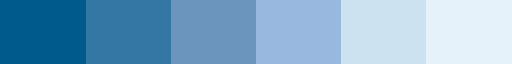

In [20]:

# Create a discrete colormap with shades of blue based on time
cmap = ListedColormap(['#005A8C', '#3477A5', '#6B95BD', '#99B8E0', '#CCE2F0', '#E6F2FA'])
cmap

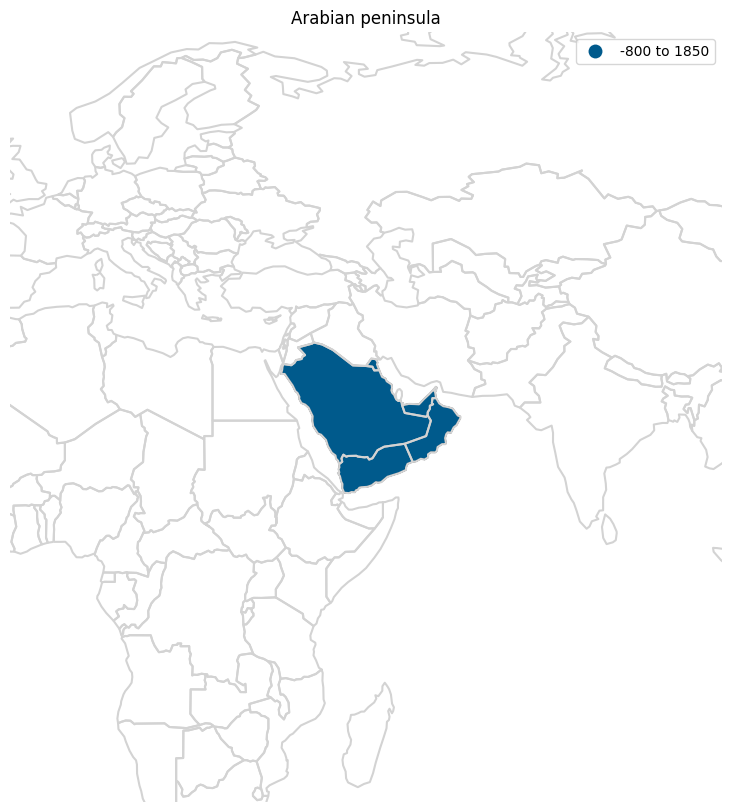

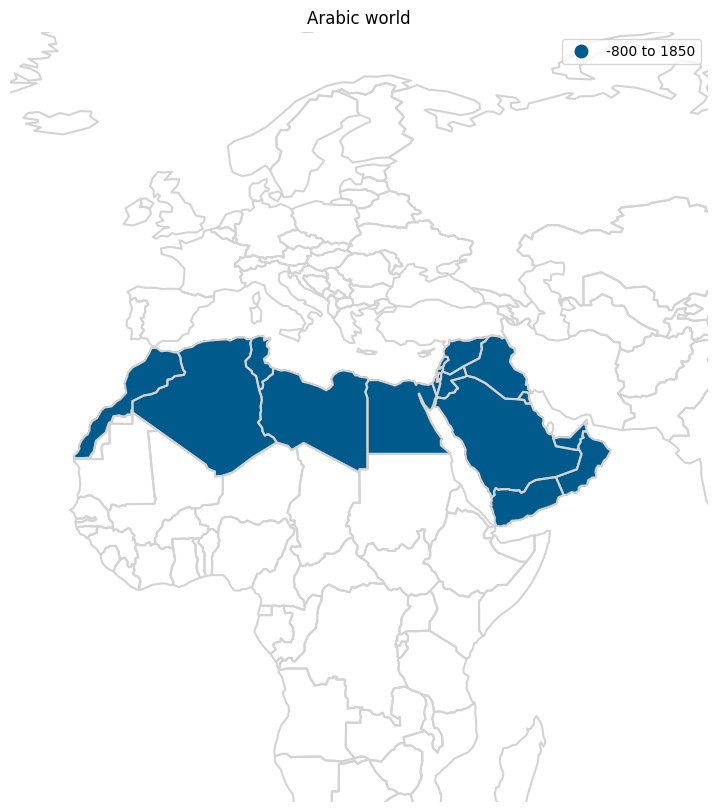

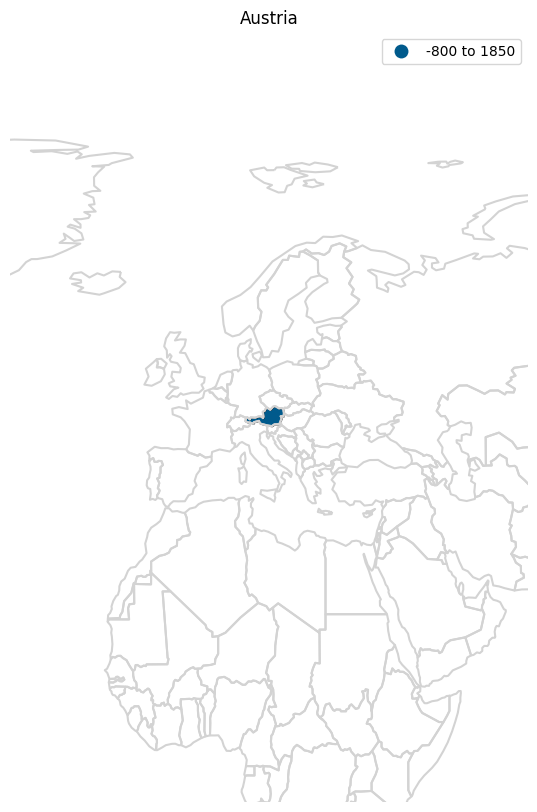

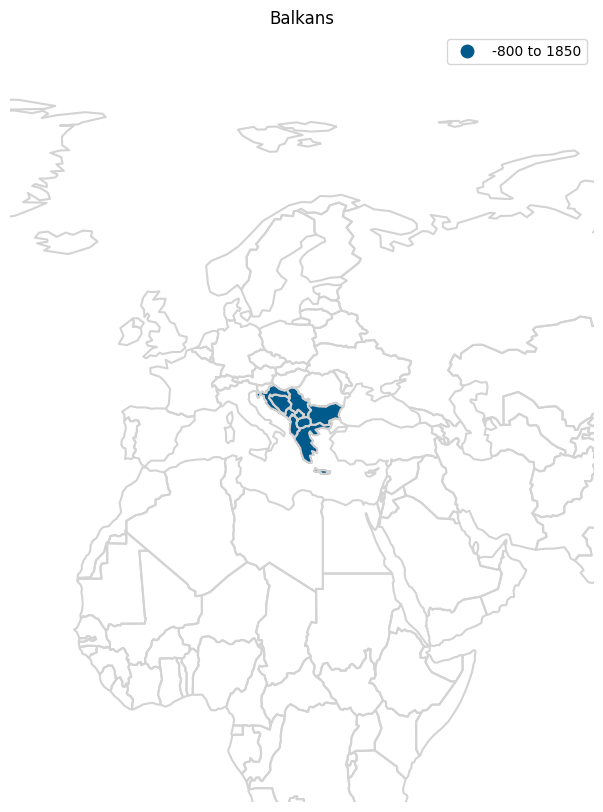

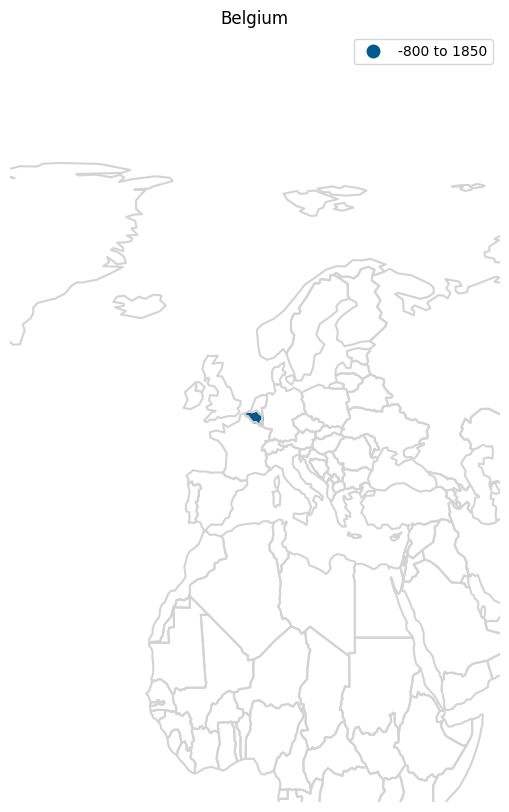

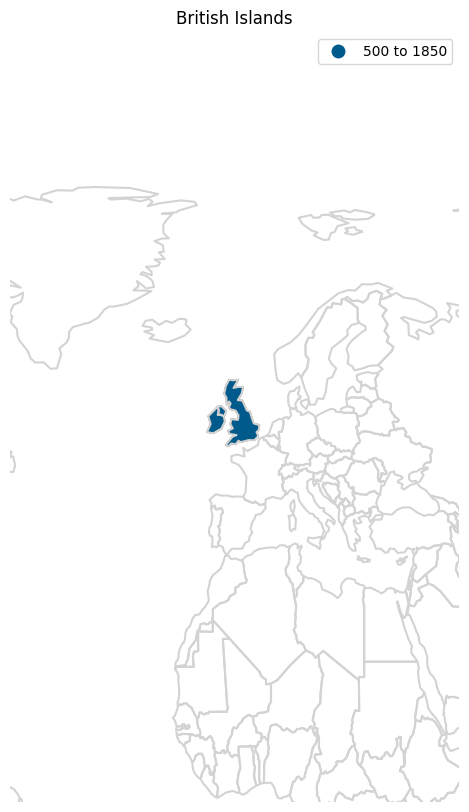

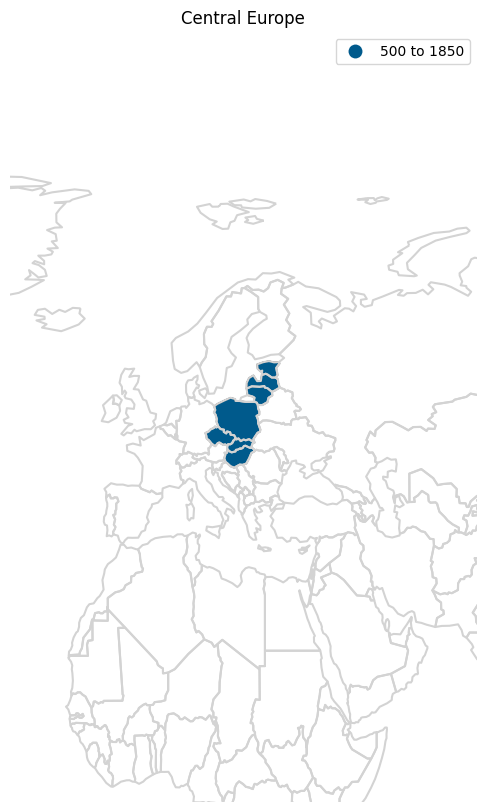

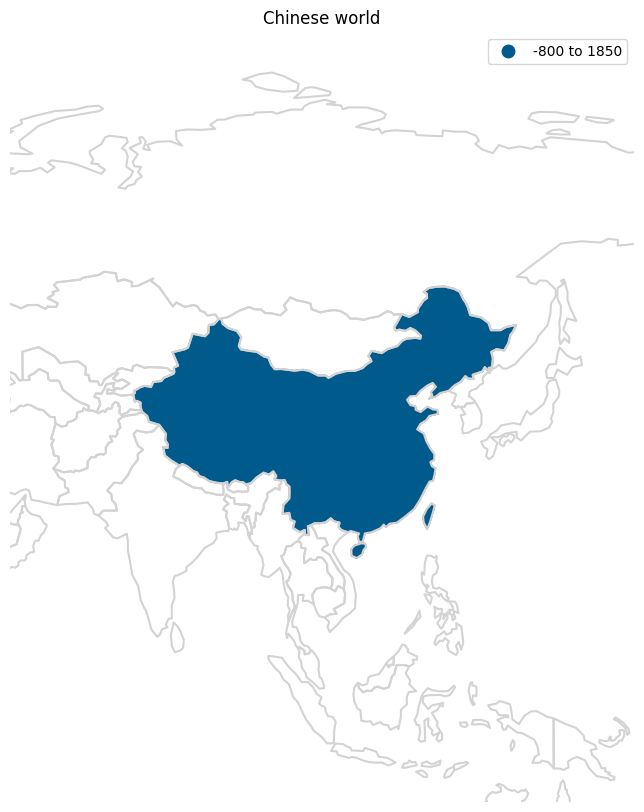

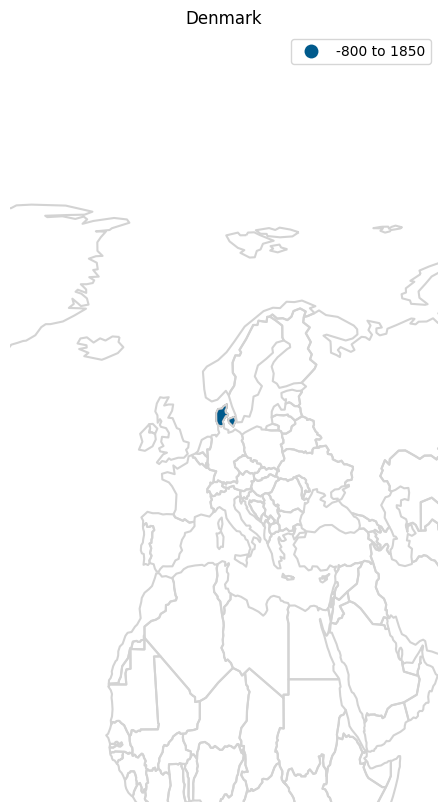

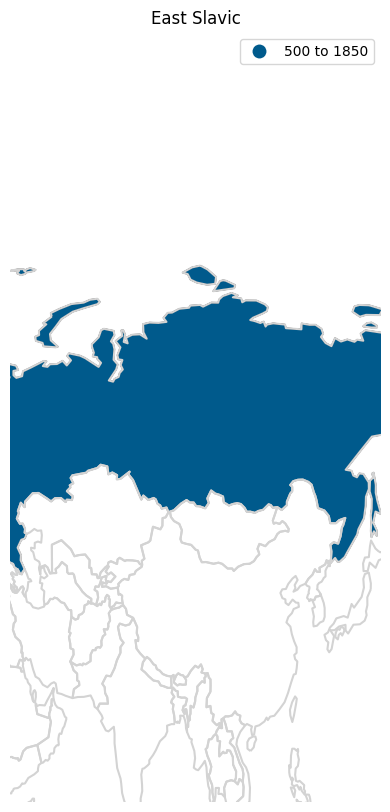

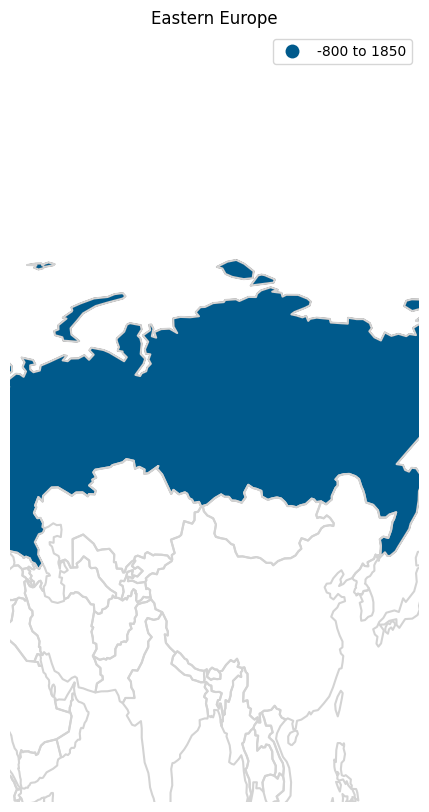

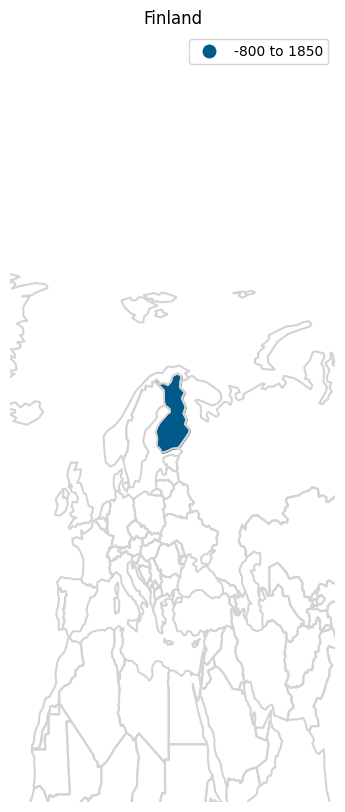

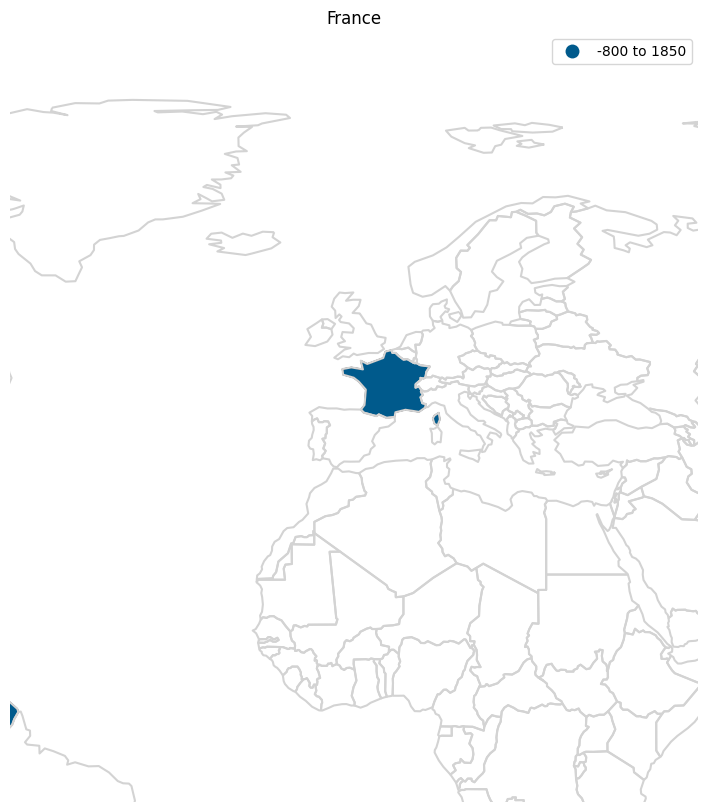

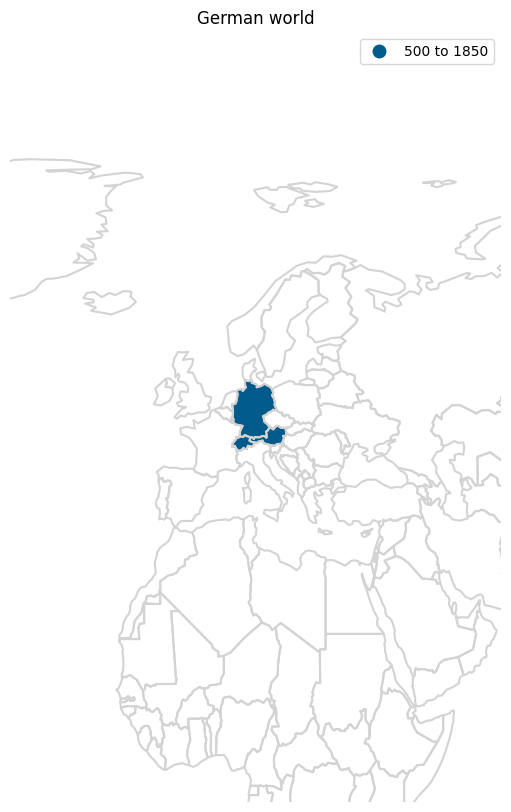

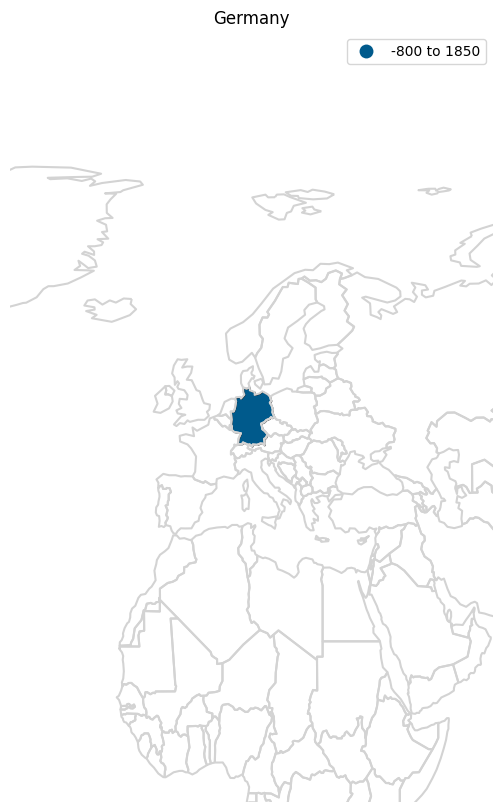

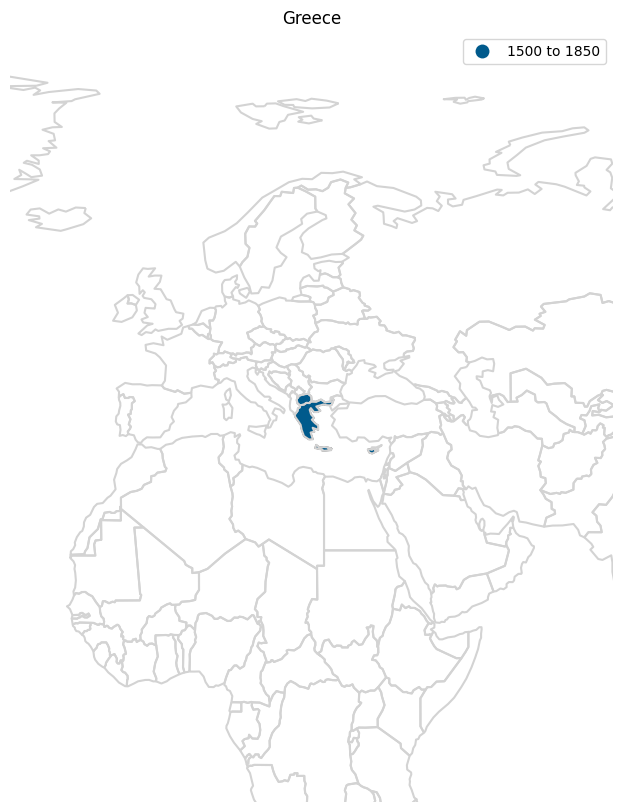

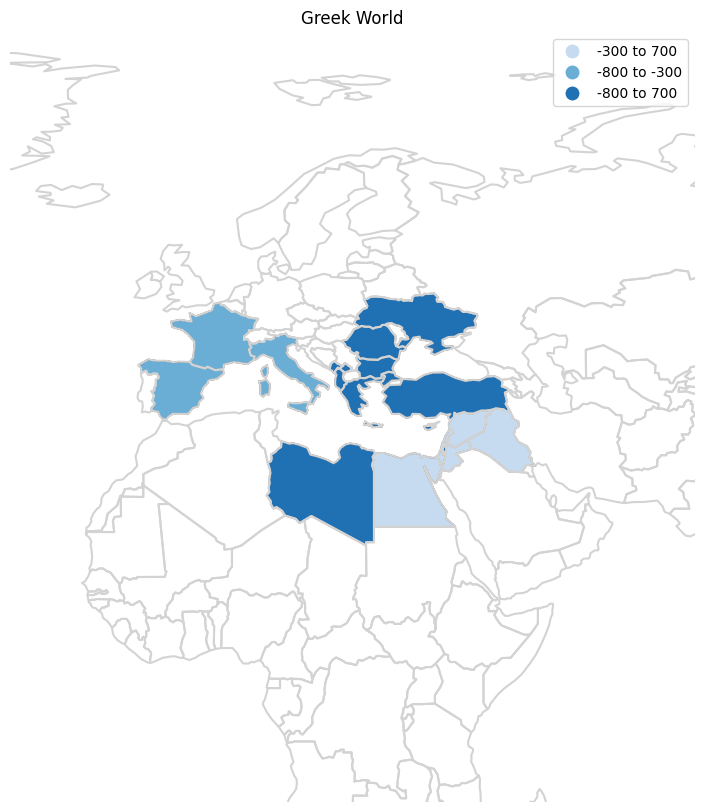

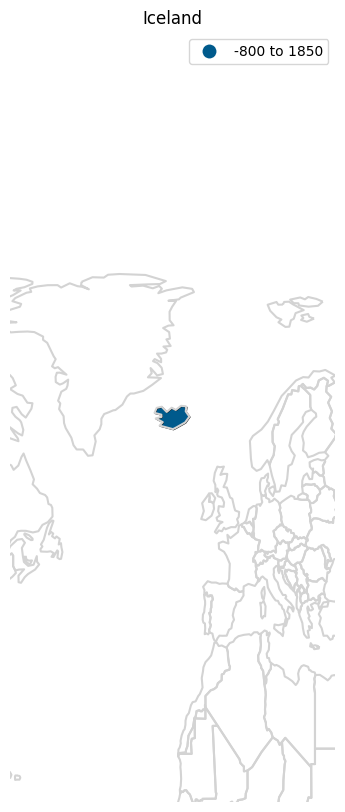

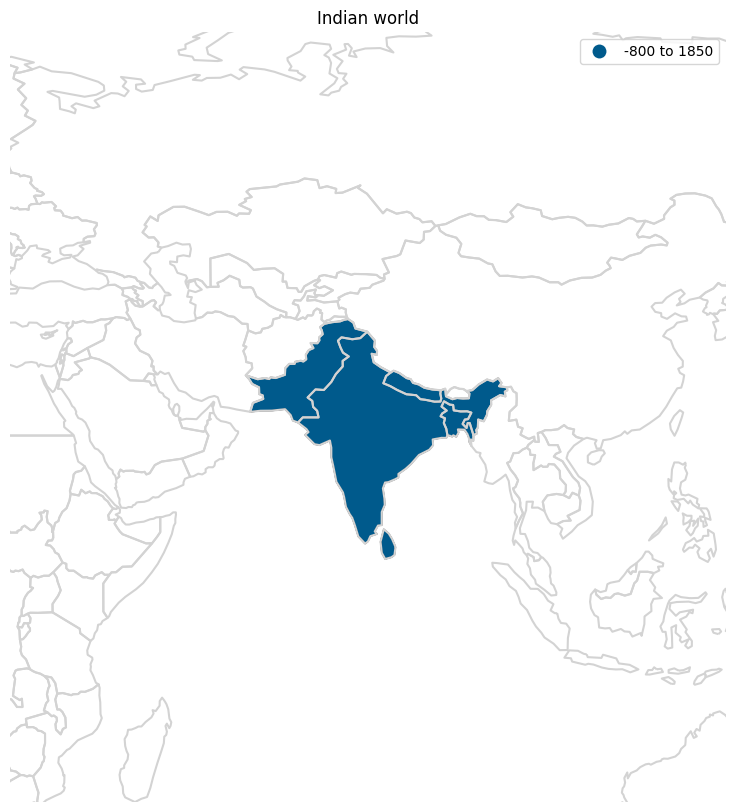

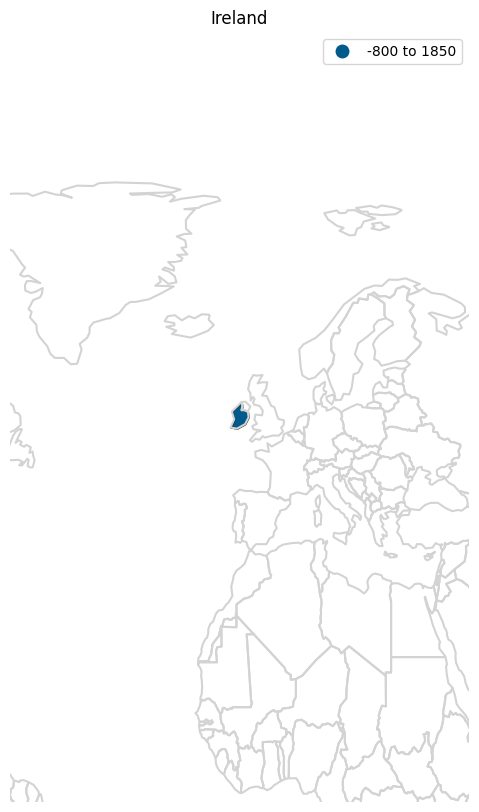

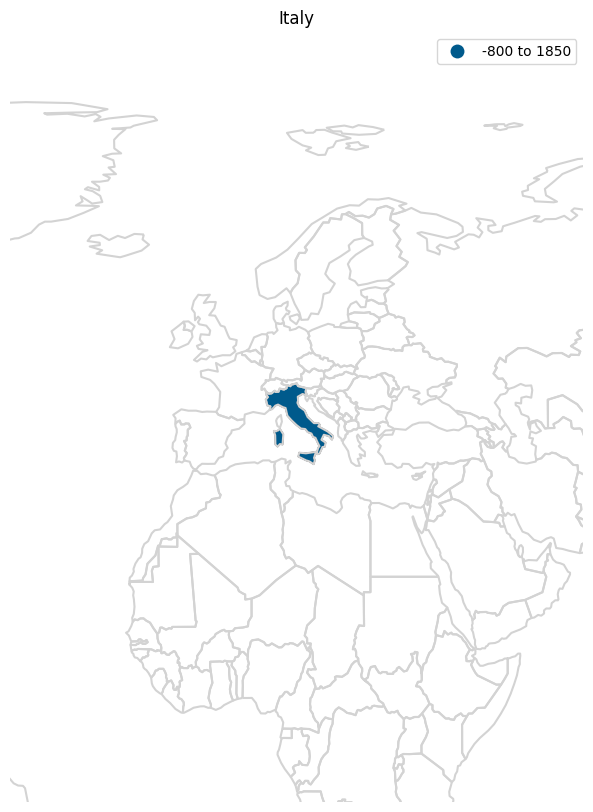

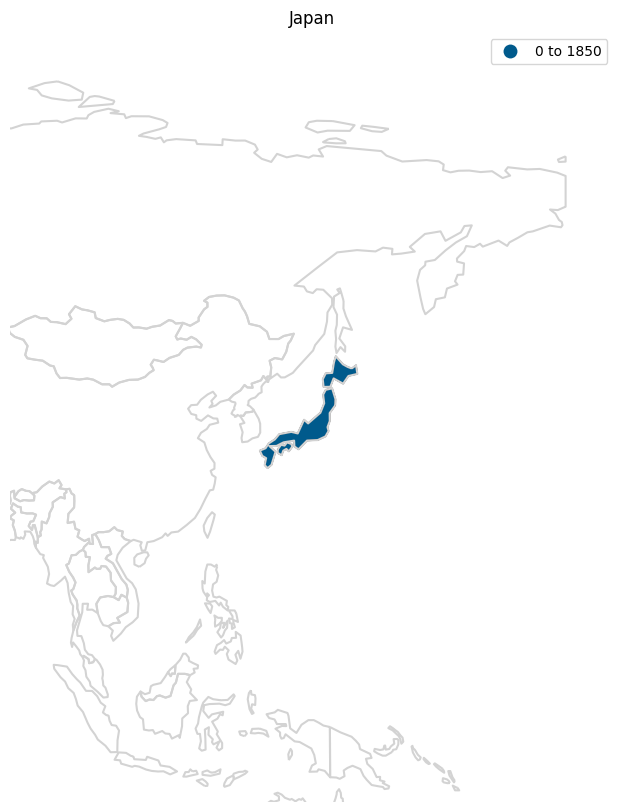

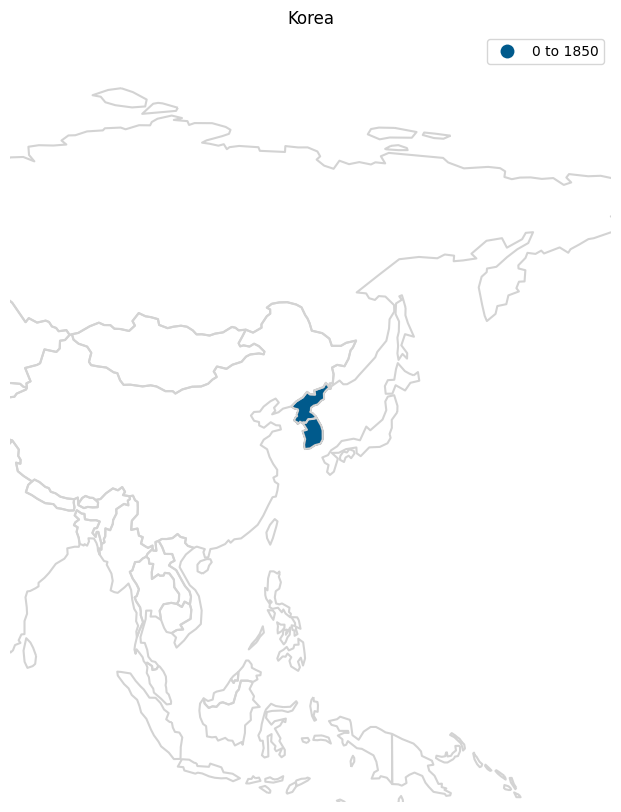

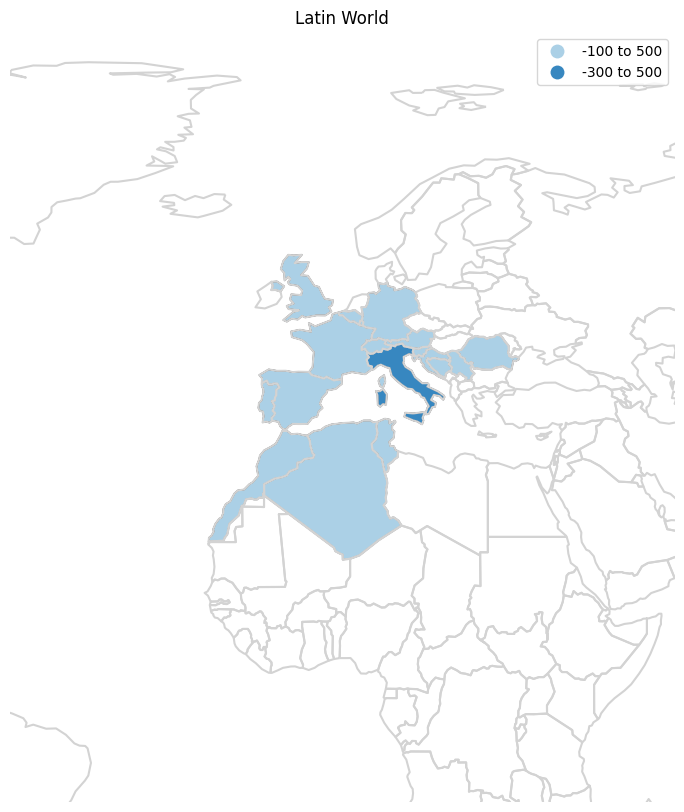

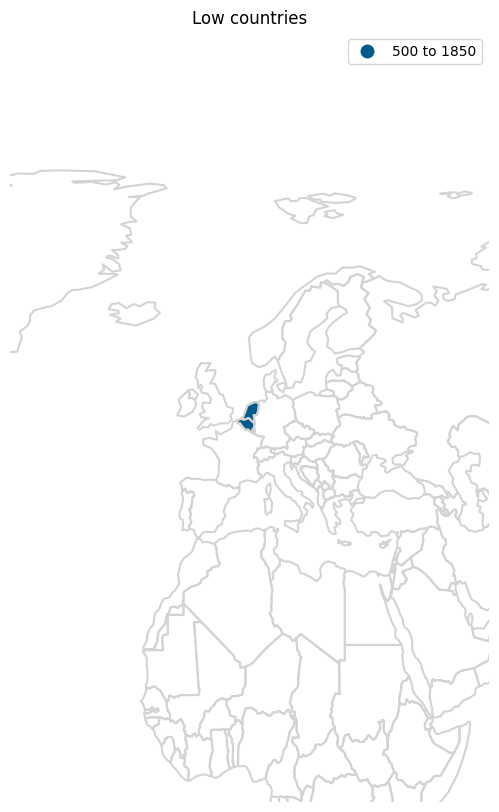

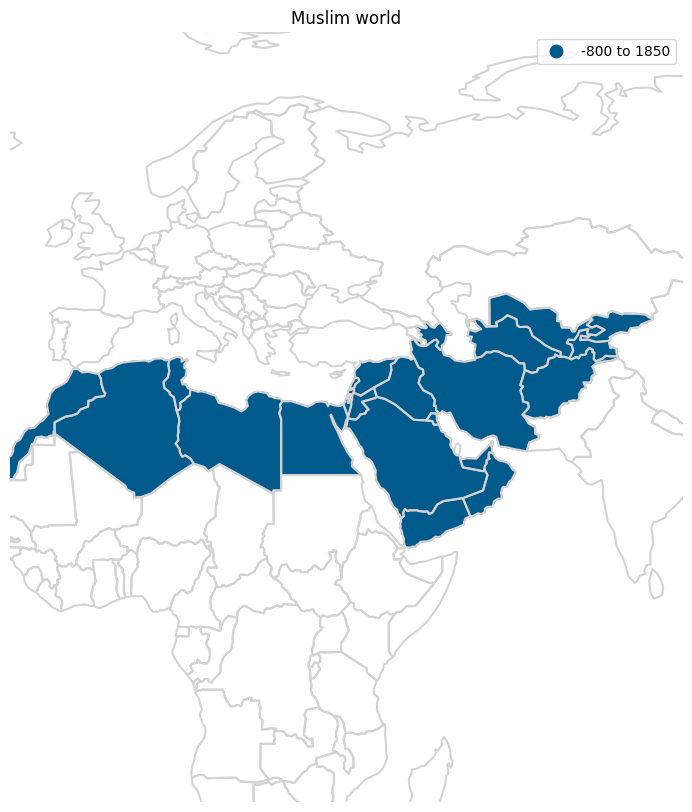

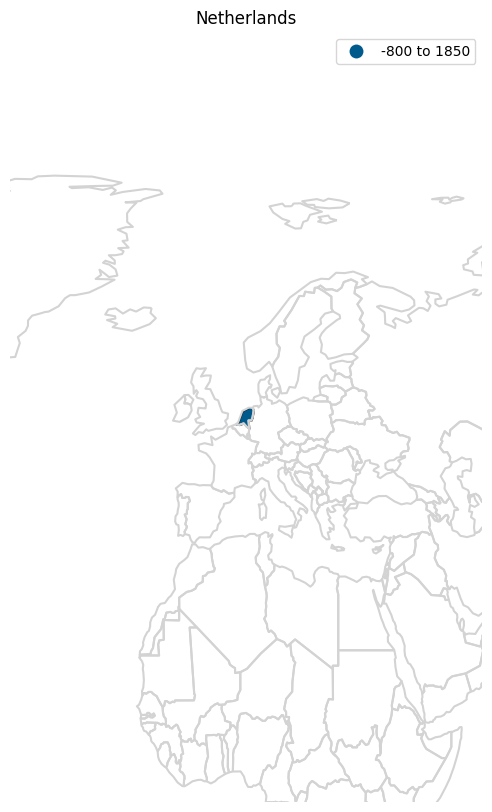

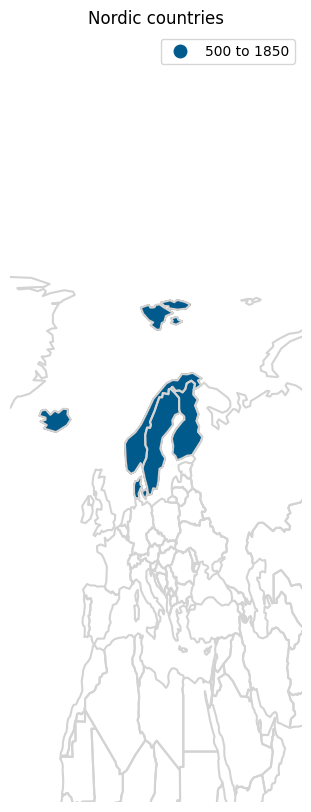

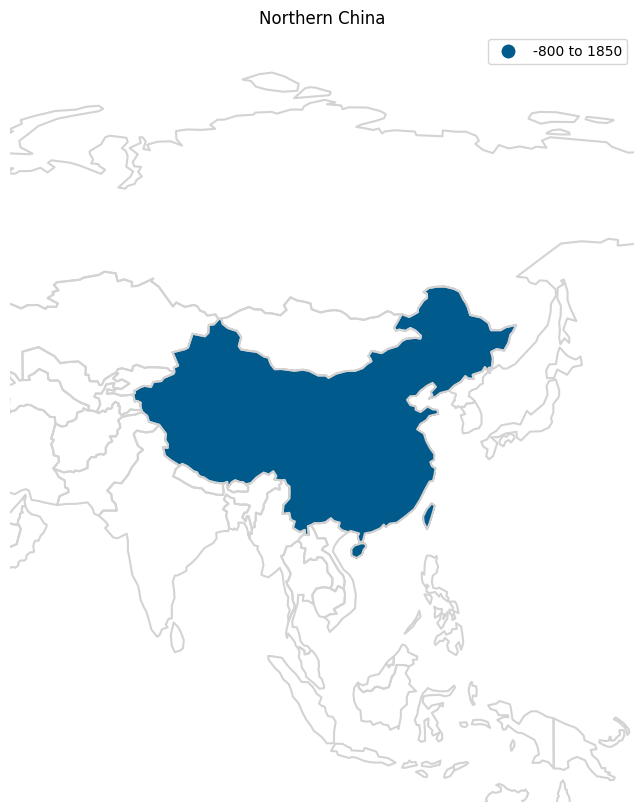

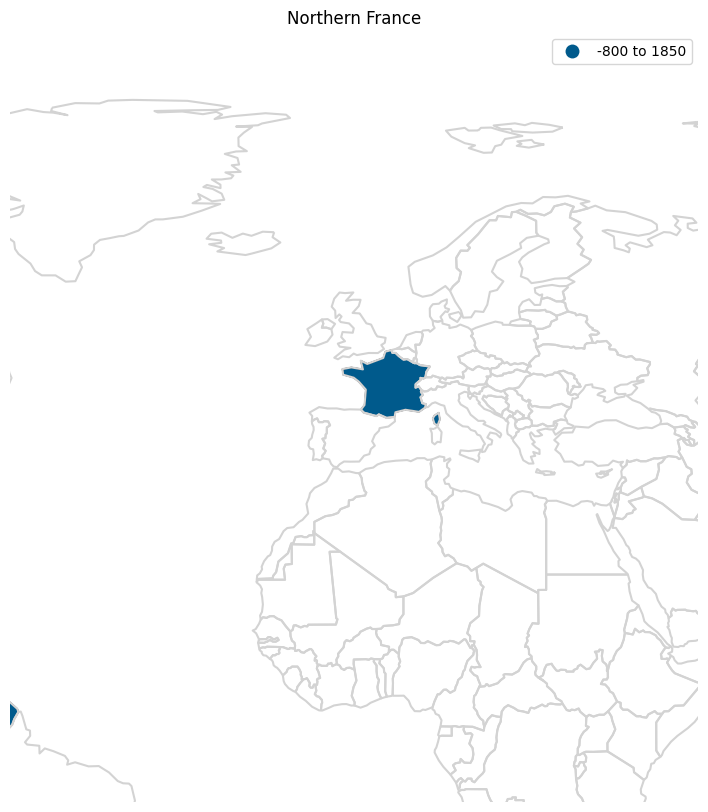

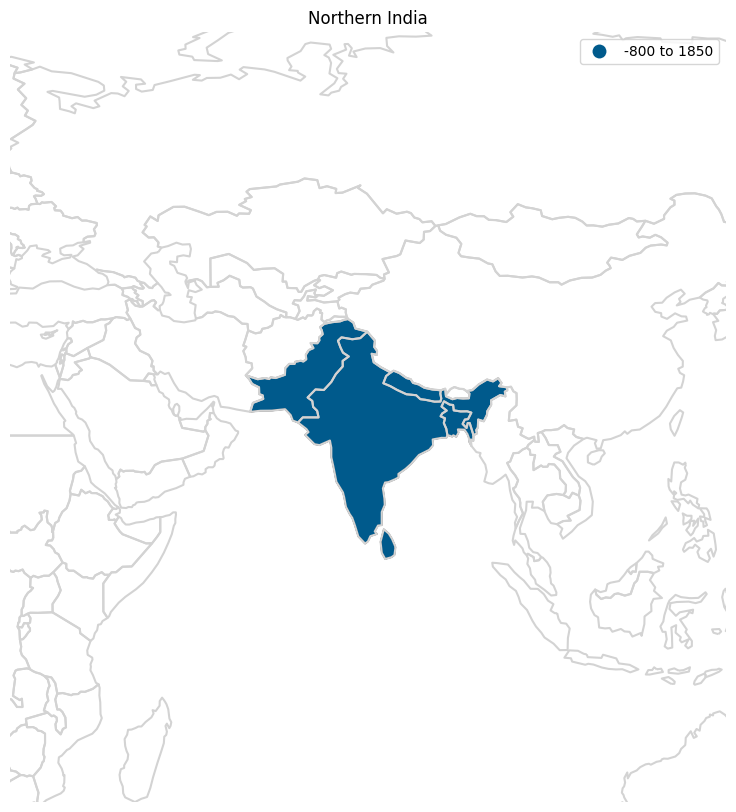

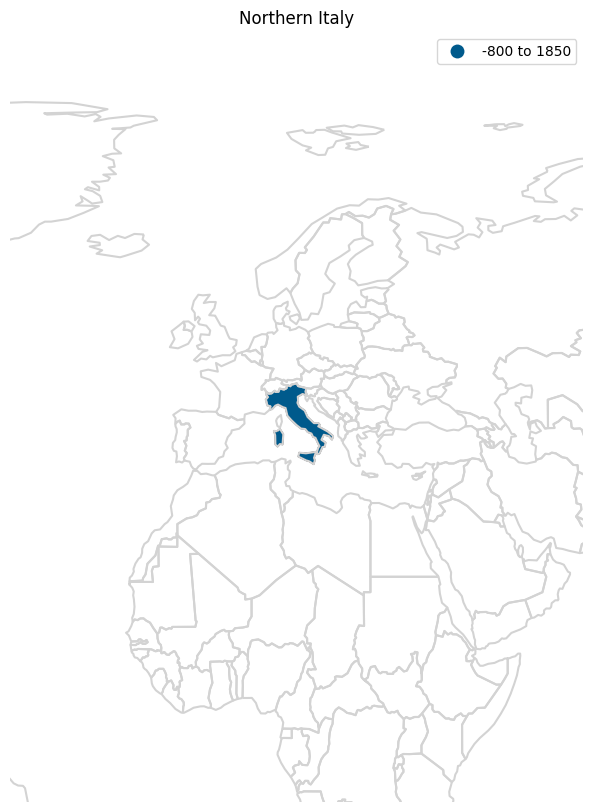

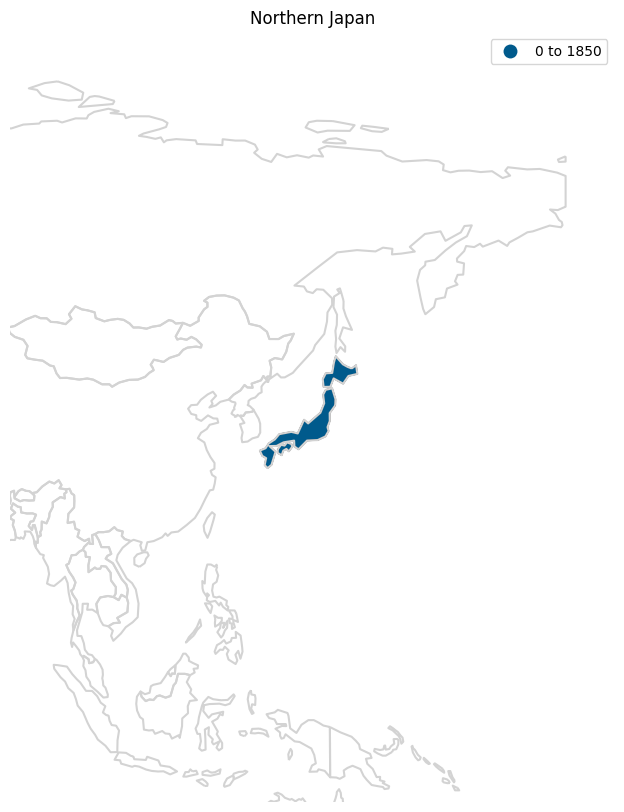

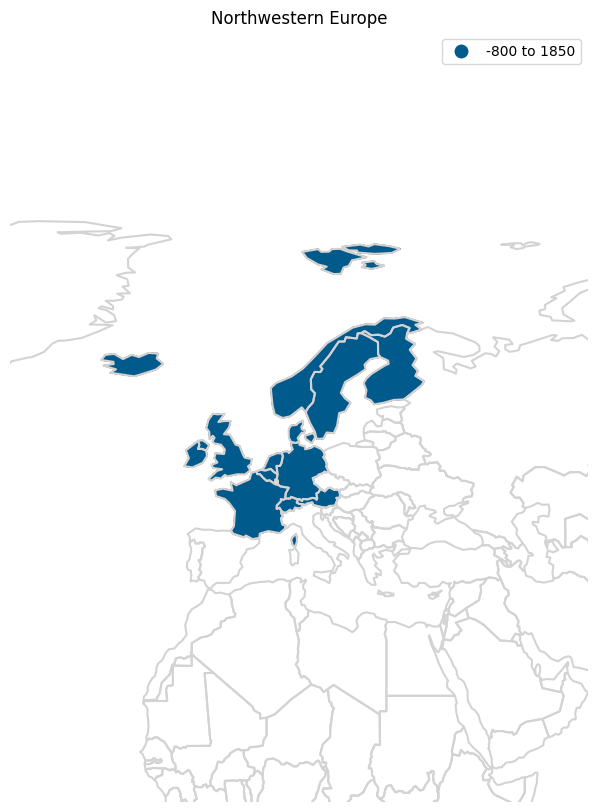

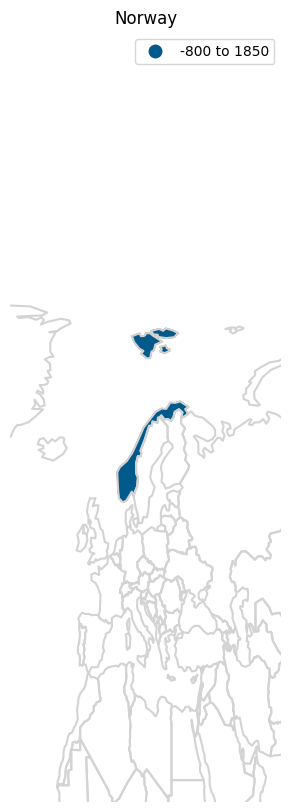

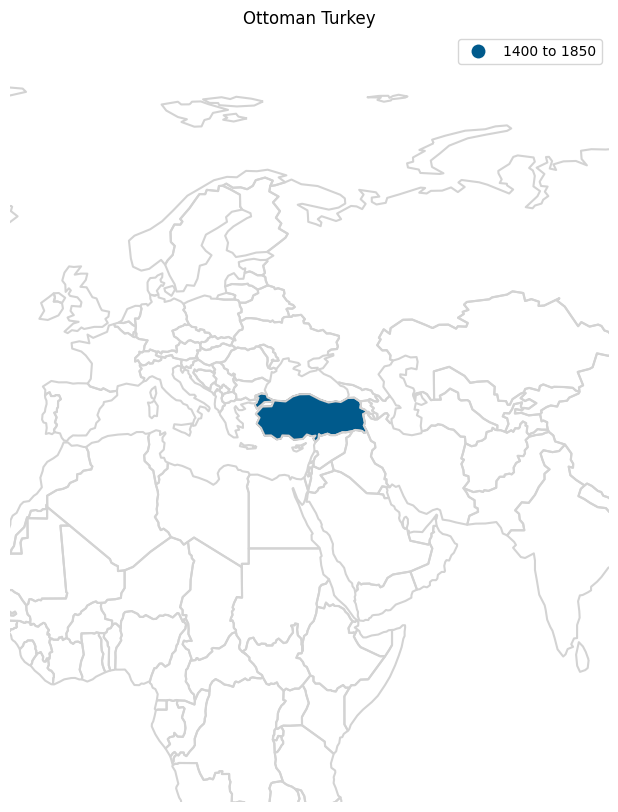

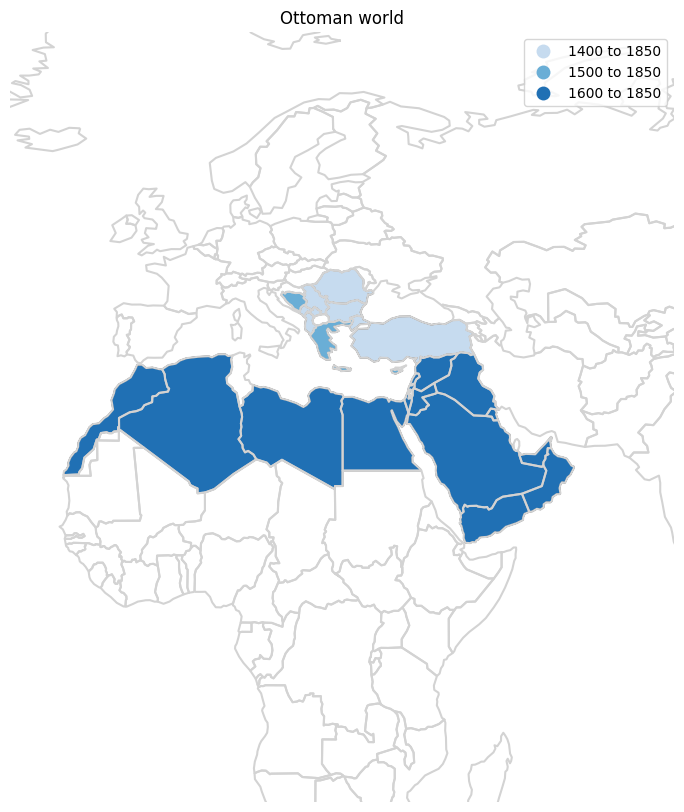

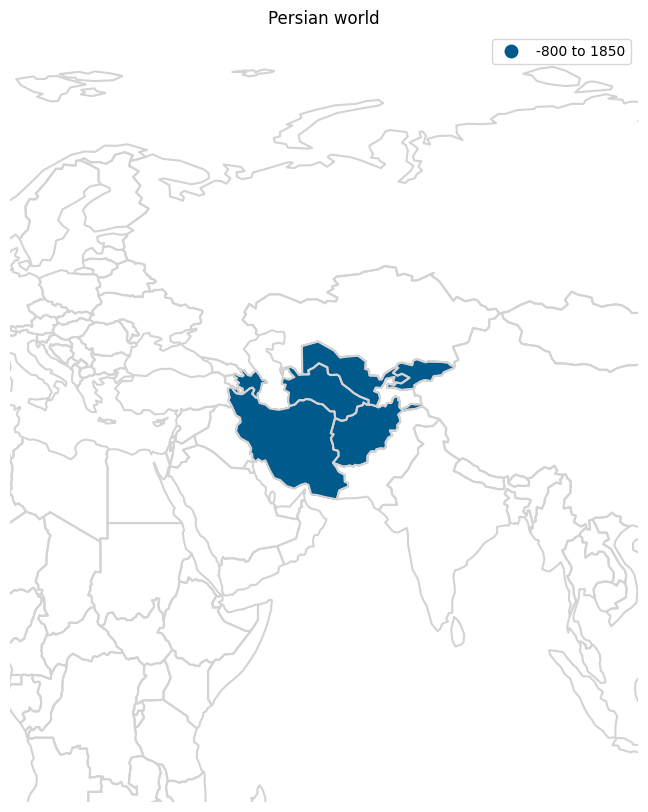

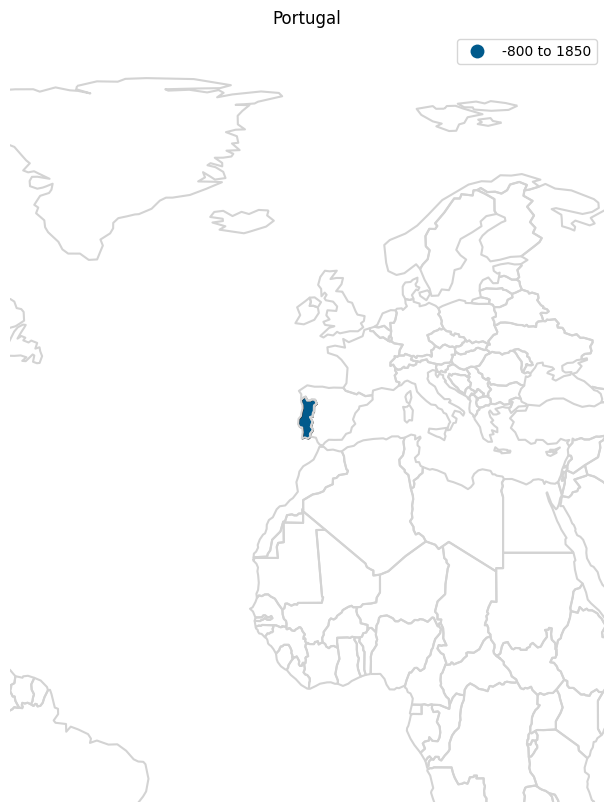

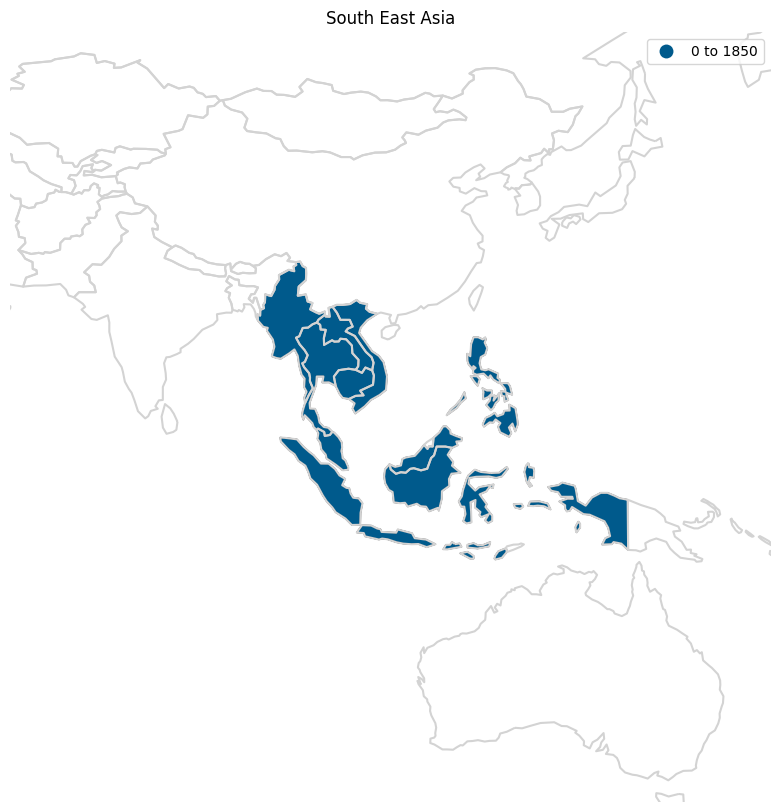

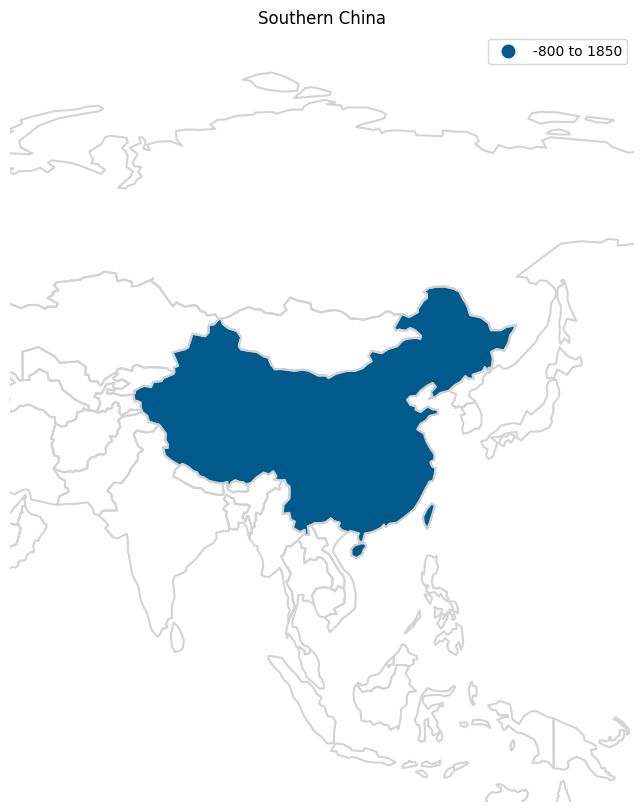

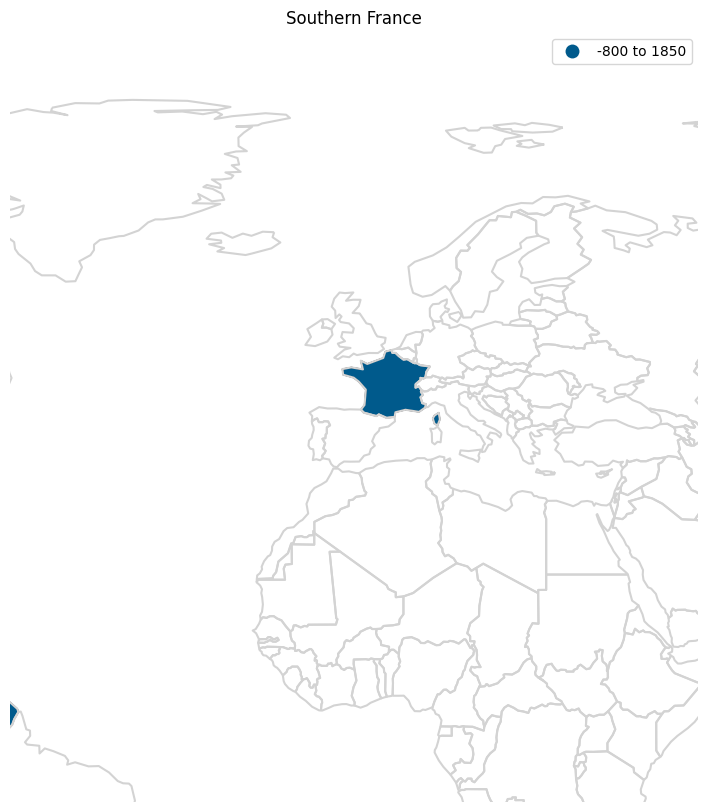

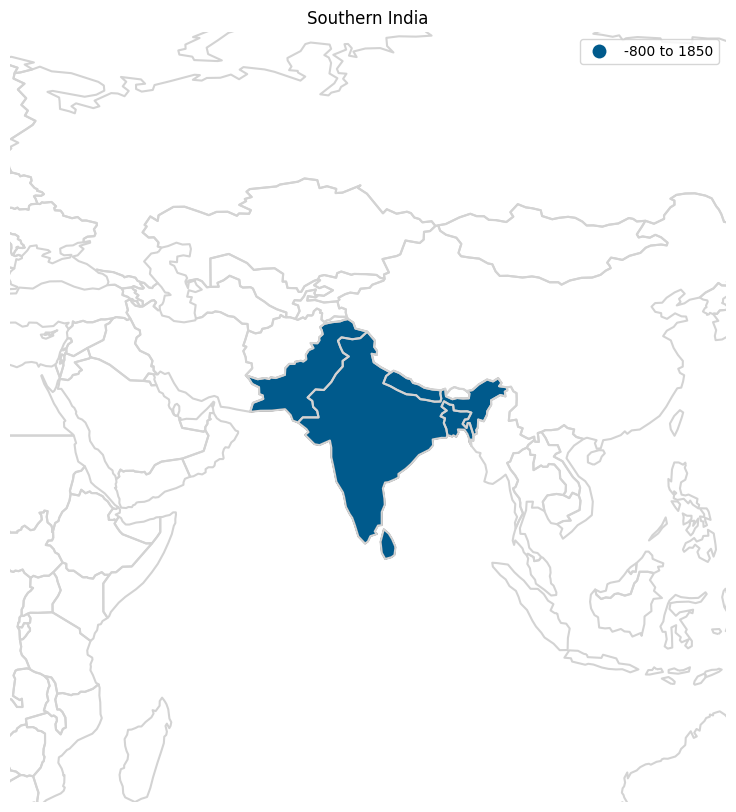

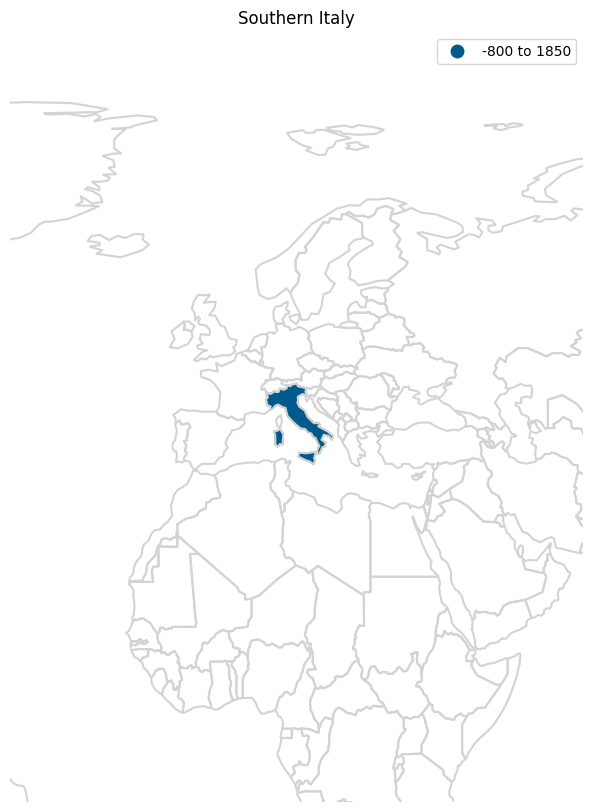

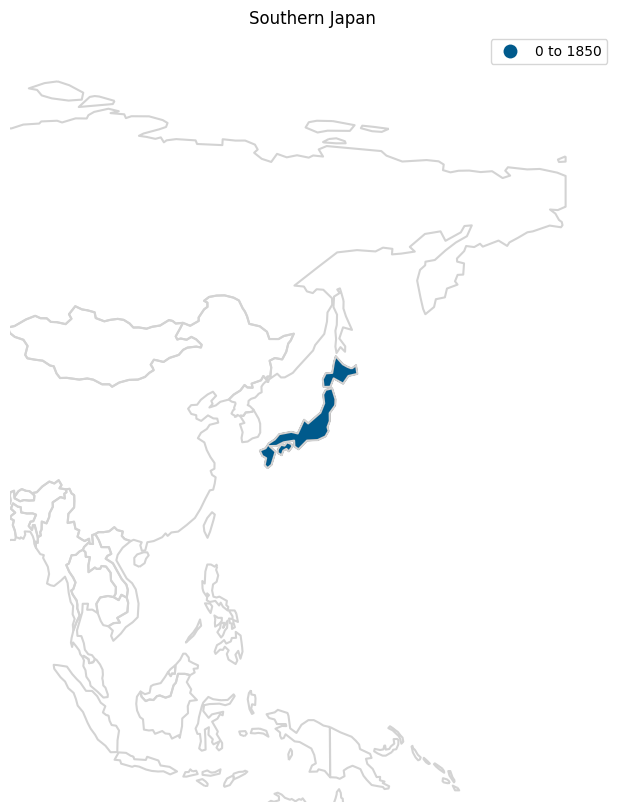

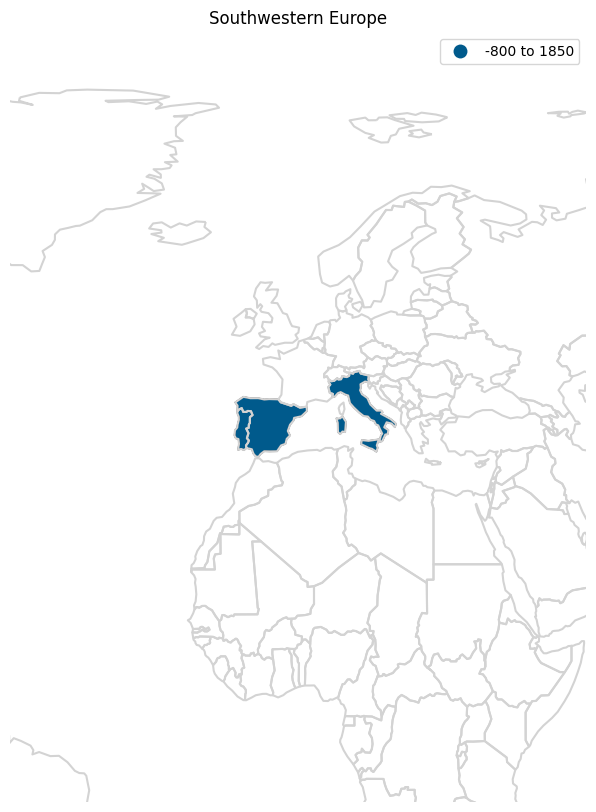

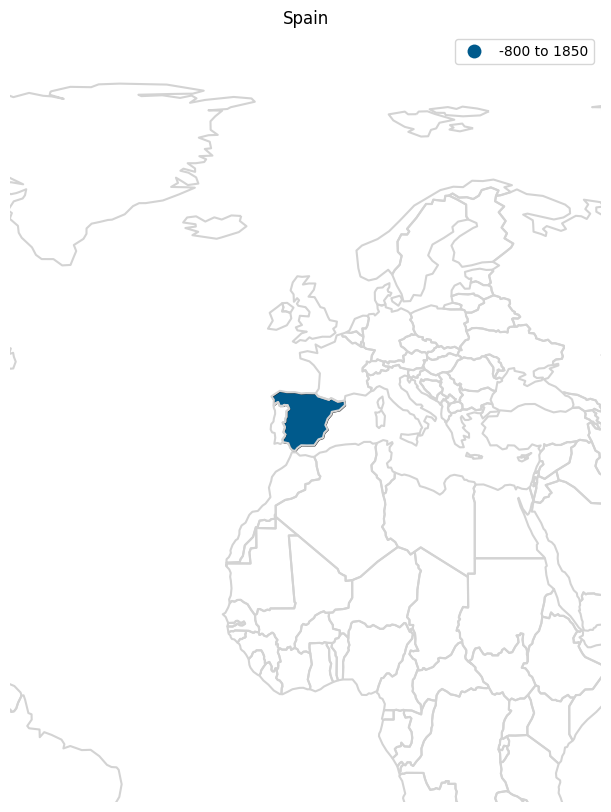

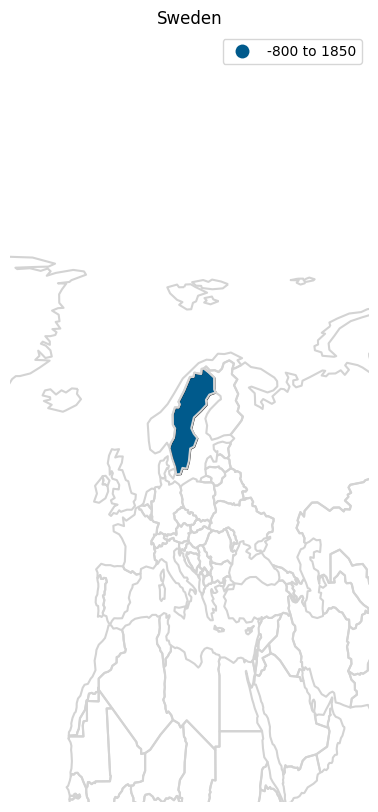

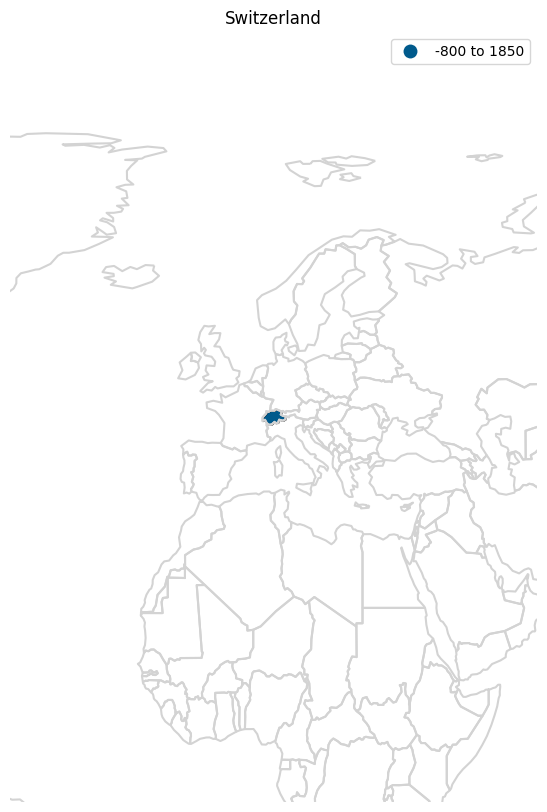

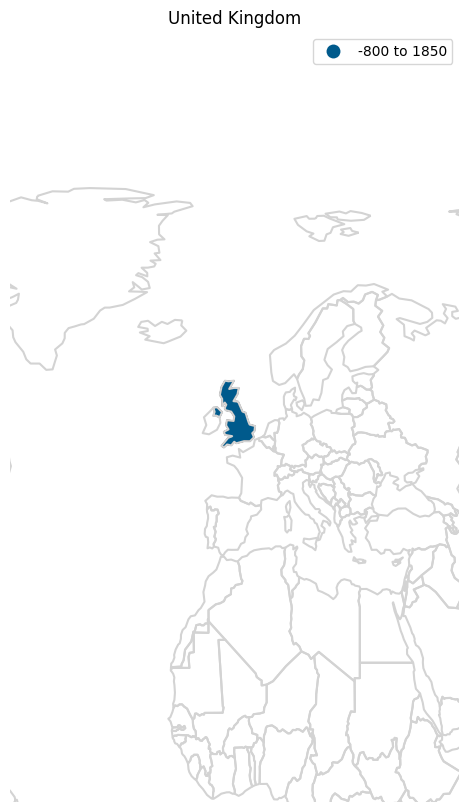

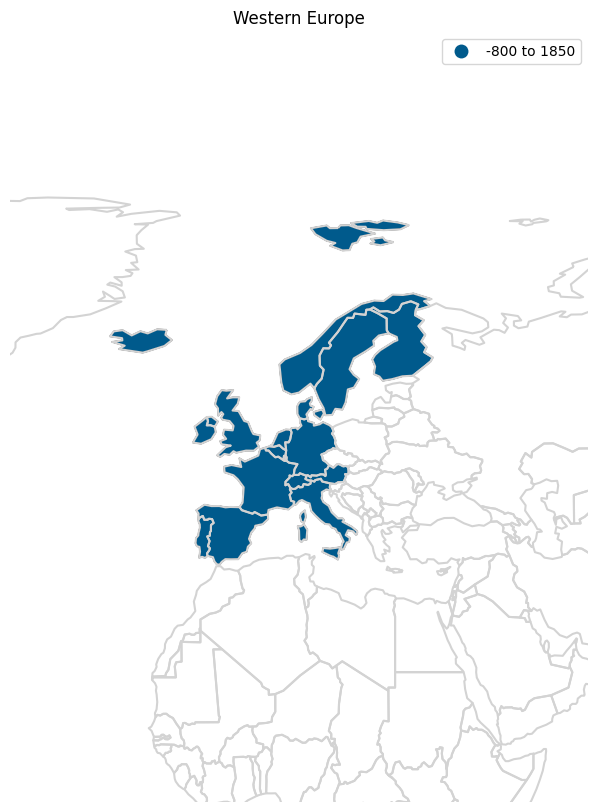

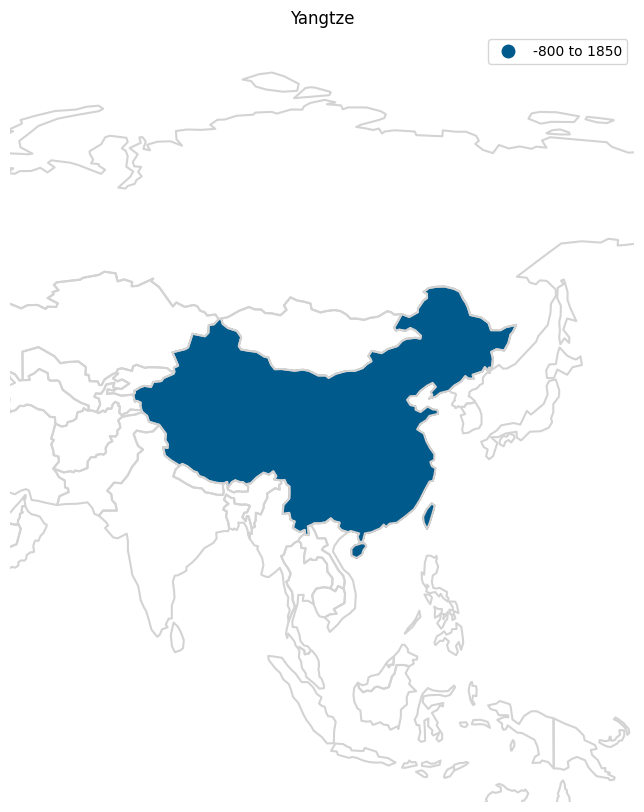

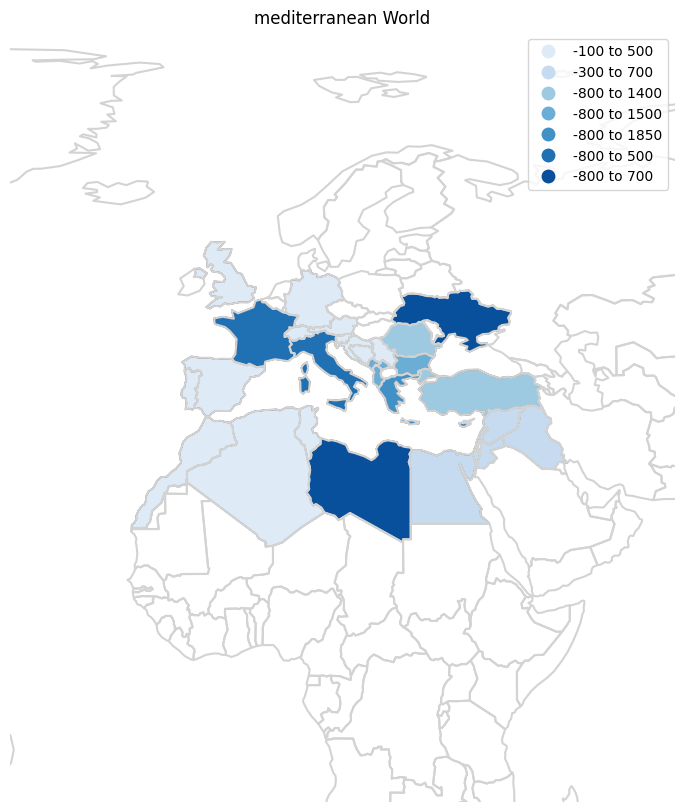

In [21]:
# Iterate through region codes and plot maps
for region_code, region_data in gdf.groupby('region'):


    # Merge with world map to get geometries
    merged_data = pd.merge(world, region_data, on='iso_a3')
    

    # Calculate the centroid of the region's geometries
    region_centroid = merged_data.geometry.unary_union.centroid

    # Plot the map centered around the region's centroid
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(region_code)

    # Set the aspect ratio to be equal for a square plot
    ax.set_aspect('equal')
    
    n=50

    # Set the map extent based on the region's centroid
    ax.set_xlim([region_centroid.x - n, region_centroid.x + n])
    ax.set_ylim([region_centroid.y - n, region_centroid.y + n])

    ax.axis('off')  # Hide the axis
    
    merged_data['unique_date'] = merged_data['min_date'].astype(int).astype(str) + ' to ' +merged_data['max_date'].astype(int).astype(str)
    merged_data = merged_data.sort_values(['min_date', 'max_date'], ascending=(True, True))
    num_unique_pairs = len(set((merged_data['unique_date'])))
    
    
    # Check if there is only one color
    if num_unique_pairs == 1:
        colors = ["#005A8C"]  # Use the specific shade of blue
    else:
        # Automatically choose a gradient of blues
        colors = sns.color_palette("Blues", num_unique_pairs)


    # Create a ListedColormap
    cmap = ListedColormap(colors)

    world.boundary.plot(ax=ax, color='lightgrey')  # Plot the world map boundaries in black
    plot = merged_data.plot(ax=ax, 
                            cmap=cmap, 
                            edgecolor='black', 
                            column='unique_date',
                            cax=False,
                            legend=True)  # Plot the region data with shades of blue
    
    
    
    gdf_filtered = gdf[gdf['region']==region_code]

    

    # Save or display the plot
    plt.savefig(f'map_figures/map_{region_code}.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()  # Display the map


# Close all plots
plt.close('all')

#### Draw One Map

In [22]:
import sys

sys.path.append('../')

from functions_env import DB_PATH
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [23]:
conn = sqlite3.connect(DB_PATH)

In [24]:
df_occupations = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
df_occupations = df_occupations[df_occupations['occupations_category'].str.contains('science')]

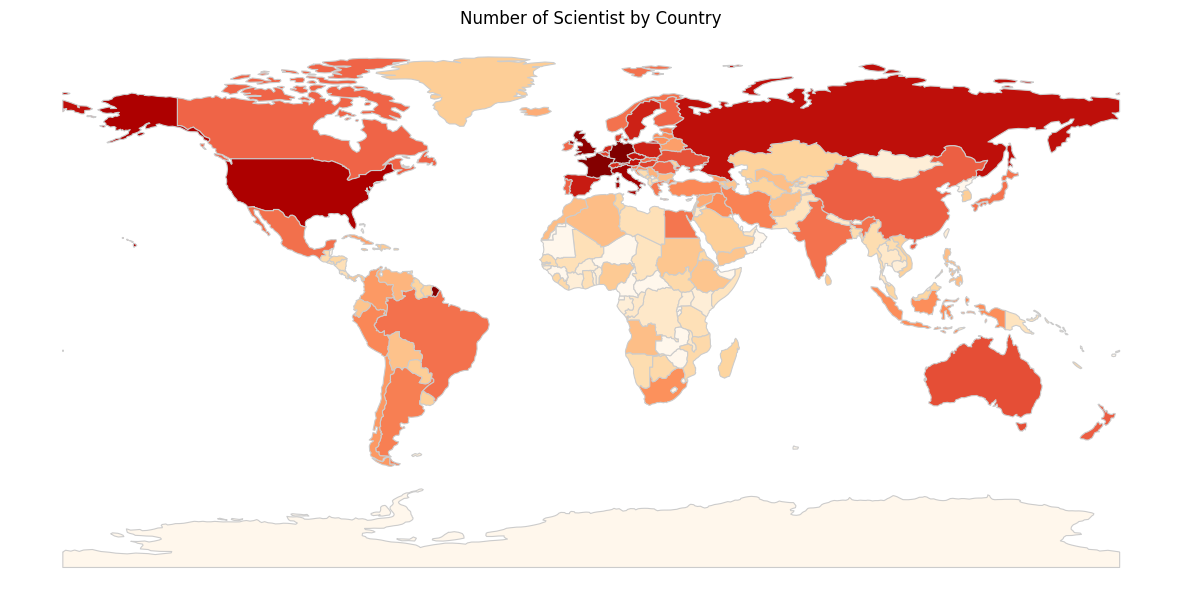

In [25]:
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'country_code', 'birthyear']]
df_individual = df_individual.dropna()
df_individual = df_individual[df_individual['birthyear']<=1850]

#kept_individuals =  pd.read_sql_query("SELECT * FROM individuals_kept", conn)
#kept_individuals = list(kept_individuals.individual_wikidata_id)

#df_final = df_individual[df_individual['individual_wikidata_id'].isin(kept_individuals)]
df_final = pd.merge(df_individual, df_occupations, on = 'individual_wikidata_id')



df_final = df_final.dropna()
df_final = df_final.rename(columns = {'country_code':'iso_a3'})

df_final = df_final.groupby('iso_a3')['individual_wikidata_id'].count().rename('count_individuals').reset_index()
df_final = df_final.sort_values('count_individuals', ascending=False)
#q = 100000

q = 100
df_final['bin'] = pd.cut(df_final['count_individuals'].rank(method= 'first'), bins=q, labels=list(np.arange(q)), precision=0)
df_final['bin'] = df_final['bin'].astype(int)
#df_final['bin'] = df_final['bin']+1

df_final['bin']= np.log(1+ df_final['count_individuals'])


# Merge the GeoDataFrame with the data
#gdf = pd.merge(df_final, world, on='iso_a3', how = 'outer')
#gdf['bin'][gdf['bin'].isna()] = 0

# Merge the GeoDataFrame with the data
gdf = world.merge(df_final, on='iso_a3', how = 'outer')
gdf = gdf.fillna(0)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='bin', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)


# Hide x and y axis
ax.set_axis_off()

# Add legend on top right
##egend = ax.get_legend()
#legend.set_bbox_to_anchor((1, 1))

# Add labels and title
ax.set_title('Number of Scientist by Country')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()